# PW7 - Sequence classification using recurrent neural networks
Objective : Classification of opinions based on film comments

# Imports

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import Embedding, LSTM, Dense


# Data
IMDB Database, giving positive/negative opinions on films. For each film, several couples (review/opinion (0/1)). 
For this study, we only consider the `num_words` most current words.

In [39]:
num_words = 10000
# Database
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=num_words)

#correspondence word -> index
word_index = imdb.get_word_index()

index->word correspondence, adding some special words

In [4]:
index = {word_id + 3: word for word, word_id in word_index.items()}
index[0] = "<pad>" # padding
index[1] = "<sos>" # start of sequence
index[2] = "<oov>" # out of vocabulary
index[3] = "<unk>" # unknown

Read review

In [5]:
def decode_review(word_ids):
    return " ".join([index.get(word_id, "<err>") for word_id in word_ids])

print("*** An example of review : ***\n ",decode_review(X_train[10]))
print("*** Corresponding opinion [positive (1)/negative (0)] : ",y_train[1]," ***")

*** An example of review : ***
  <sos> french horror cinema has seen something of a revival over the last couple of years with great films such as inside and <oov> romance <oov> on to the scene <oov> <oov> the revival just slightly but stands head and shoulders over most modern horror titles and is surely one of the best french horror films ever made <oov> was obviously shot on a low budget but this is made up for in far more ways than one by the originality of the film and this in turn is <oov> by the excellent writing and acting that ensure the film is a winner the plot focuses on two main ideas prison and black magic the central character is a man named <oov> sent to prison for fraud he is put in a cell with three others the quietly insane <oov> body building <oov> marcus and his retarded boyfriend daisy after a short while in the cell together they stumble upon a hiding place in the wall that contains an old <oov> after <oov> part of it they soon realise its magical powers and real

# Models

## Baseline
Baseline model (provided), in order to compare the results to the recurrent neural network model

In [97]:
X_train_text = [decode_review(words_ids) for words_ids in X_train]
X_test_text =[decode_review(words_ids) for words_ids in X_test]

In [98]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
processing = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', SGDClassifier(max_iter=50)),])
processing.fit(X_train_text, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(max_iter=50))])

In [99]:
print("Baseline accuracy on the test set: we have to do better than this !!: ",processing.score(X_test_text, y_test))
print("Model testing  (ground truth: 0): ", processing.predict(["Awful !"]))
print("Model testing (ground truth: 1): ", processing.predict(["Fantastic !"]))

Baseline accuracy on the test set: we have to do better than this !!:  0.88492
Model testing  (ground truth: 0):  [0]
Model testing (ground truth: 1):  [1]


## LSTM Model

First transform X_train (and X_test) into  2D array of shape (X_train.shape[0], maxlen) ((X_test.shape[0], maxlen)). X_train[i]  (X_test[i]) is a sequence of samples 
(a set of word indexes). There are X_train.shape[0]  (X_test.shape[0]) sequences, all with different lengths (the reviews)
So the function pads the sequences to the same dimension with padding values = 0 (default) : see [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences)



In [100]:
maxlen = 500
X_train_trim = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)

Model : sequential model composed of 
- An [embedding](https://keras.io/api/layers/core_layers/embedding/) layer : the size of the vocabulary (input_dim) is given by the number of words. The size of the embedding space is the output_dim (see summary)
- An [LSTM](https://keras.io/api/layers/recurrent_layers/lstm/) with a given number of units (see summary)
- A [dense](https://keras.io/api/layers/core_layers/dense/) layer for the prediction

In [7]:
model = tf.keras.models.Sequential()
model.add(Embedding(input_dim=num_words, output_dim=10))
model.add(LSTM(32))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 10)          100000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                5504      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 105,537
Trainable params: 105,537
Non-trainable params: 0
_________________________________________________________________


Compile and train the model. Use `binary_crossentropy` as a loss and `RMSProp`as optimizer. Track the accuracy

In [101]:
batch_size = 128
num_epochs = 20

model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
history = model.fit(X_train_trim, y_train,epochs=num_epochs, batch_size=batch_size)

Epoch 1/20
196/196 [==============================] - 30s 152ms/step - loss: 0.2545 - accuracy: 0.9030
Epoch 2/20
196/196 [==============================] - 26s 132ms/step - loss: 0.2156 - accuracy: 0.9182
Epoch 3/20
196/196 [==============================] - 26s 132ms/step - loss: 0.1905 - accuracy: 0.9306
Epoch 4/20
196/196 [==============================] - 27s 139ms/step - loss: 0.1723 - accuracy: 0.9368
Epoch 5/20
196/196 [==============================] - 27s 136ms/step - loss: 0.1572 - accuracy: 0.9442
Epoch 6/20
196/196 [==============================] - 26s 134ms/step - loss: 0.1485 - accuracy: 0.9475
Epoch 7/20
196/196 [==============================] - 28s 141ms/step - loss: 0.1381 - accuracy: 0.9516
Epoch 8/20
196/196 [==============================] - 27s 136ms/step - loss: 0.1274 - accuracy: 0.9560
Epoch 9/20
196/196 [==============================] - 28s 141ms/step - loss: 0.1218 - accuracy: 0.9575
Epoch 10/20
196/196 [==============================] - 27s 137ms/step - l

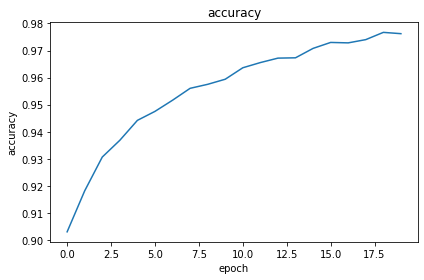

In [102]:
# if `history`is the output of your fit.
plt.plot(history.history['accuracy'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.tight_layout()

In [92]:
def encode_review(toto):
    l = []
    l = [word_index.get(word) for word in toto]
    l = [l[i :(i+1)] for i in range(len(l))]
    l = tf.keras.preprocessing.sequence.pad_sequences(l, maxlen=maxlen)
    return l

In [96]:
print("Loss / Accuracy on the test set: ",model.evaluate(X_test_trim, y_test)) # to compare with the baseline
negative = ["awful"]
negative = encode_review(negative)
print("Model testing  (ground truth: 0): ", model.predict_classes(negative))

positive = ["fantastic"]
positive = encode_review(positive)
print("Model testing  (ground truth: 1): ", model.predict_classes(positive))


782/782 [==============================] - 15s 19ms/step - loss: 0.3095 - accuracy: 0.8786
Loss / Accuracy on the test set:  [0.30945396423339844, 0.8786399960517883]
Model testing  (ground truth: 0):  [[0]]
Model testing  (ground truth: 1):  [[1]]


# Some ways to test/improve the method

- Change the size of the vocabulary
- change the size of the padding
- Change the dimension of the embedding space
- Change the number of units of the LSTM
- Change the model (The [Keras website](https://keras.io/examples/nlp/text_classification_from_scratch/) proposes another model on the same database, you can be inspired from it)
- 

... and analyze how it improves (or not) the model


